In [58]:
from analysis_utils import prepare_df, aggregate_by_fields
import json
import numpy as np
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [93]:
# verdict_group_batch = "raljs5b"
# verdict_group_batch = "orz1gnj"
# verdict_group_batch = "5ot6r19"
# verdict_group_batch = "83284bs"
verdict_group_batch = "7i08qzy"

In [94]:
with open(f"../results/verdict_groups/{verdict_group_batch}.json", "r") as f:
    data = json.load(f)

verdict_ids = []
for run in data["runs"]:
    verdict_ids.append(run['verdict_run_id'])

In [95]:
all_df = prepare_df(specific_verdict_ids=verdict_ids)

/Users/joshlevy/projects/llm_judge_debate_NEW/analysis/analysis_utils.py:51: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  config_df = pd.json_normalize(df['config'])


In [96]:
verdicts_df = all_df[all_df['verdict_run_id_verdicts'].isin(verdict_ids)]
verdicts_df.shape

(742, 87)

In [97]:
verdicts_df[['verdict_run_id_verdicts', 'config_debate_run_id_verdicts', 'config_judge_model_verdicts']].value_counts()

verdict_run_id_verdicts  config_debate_run_id_verdicts  config_judge_model_verdicts     
8yas9a0                  ts9ga4y                        meta-llama/llama-3.1-8b-instruct    187
9hbpsuo                  ts9ga4y                        meta-llama/llama-3.1-8b-instruct    186
mdmimjp                  ts9ga4y                        meta-llama/llama-3.1-8b-instruct    186
9p592lz                  ts9ga4y                        meta-llama/llama-3.1-8b-instruct    183
Name: count, dtype: int64

In [98]:
# Showing that repetitions actually have consideralbe variability - 90% in this case - even though average verdict performance come out similar (flipping)

# set1 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == 'zv74feq']
# set2 = verdicts_df[verdicts_df['verdict_run_id_verdicts'] == '4j31cg4']

# merge = set1[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']].merge(set2[['is_correct_verdict', 'question_idx_debates', 'verdict_run_id_verdicts', 'record_id_debates']], on=['question_idx_debates'])

# (merge['is_correct_verdict_x'] == merge['is_correct_verdict_y']).sum() / merge.shape[0]


In [99]:
aggregate_acc = aggregate_by_fields(verdicts_df, fields=['verdict_run_id_verdicts'])
aggregate_acc

,debater_qa_acc,judge_qa_acc,verdict_acc,debater_qa_n_correct,judge_qa_n_correct,verdict_n_correct,n_total,n_verdict_not_null,n_judge_qa_not_null,n_debater_qa_not_null,pgr,gap,gain,name
0,0.935829,0.517442,0.647059,175,89,121,187,187,172,187,0.309802,0.418387,0.129617,8yas9a0
1,0.935484,0.529412,0.709677,174,90,132,186,186,170,186,0.443925,0.406072,0.180266,9hbpsuo
2,0.939891,0.497006,0.633880,172,83,116,183,183,167,183,0.309051,0.442885,0.136874,9p592lz
3,0.930108,0.514620,0.516129,173,88,96,186,186,171,186,0.003632,0.415488,0.001509,mdmimjp


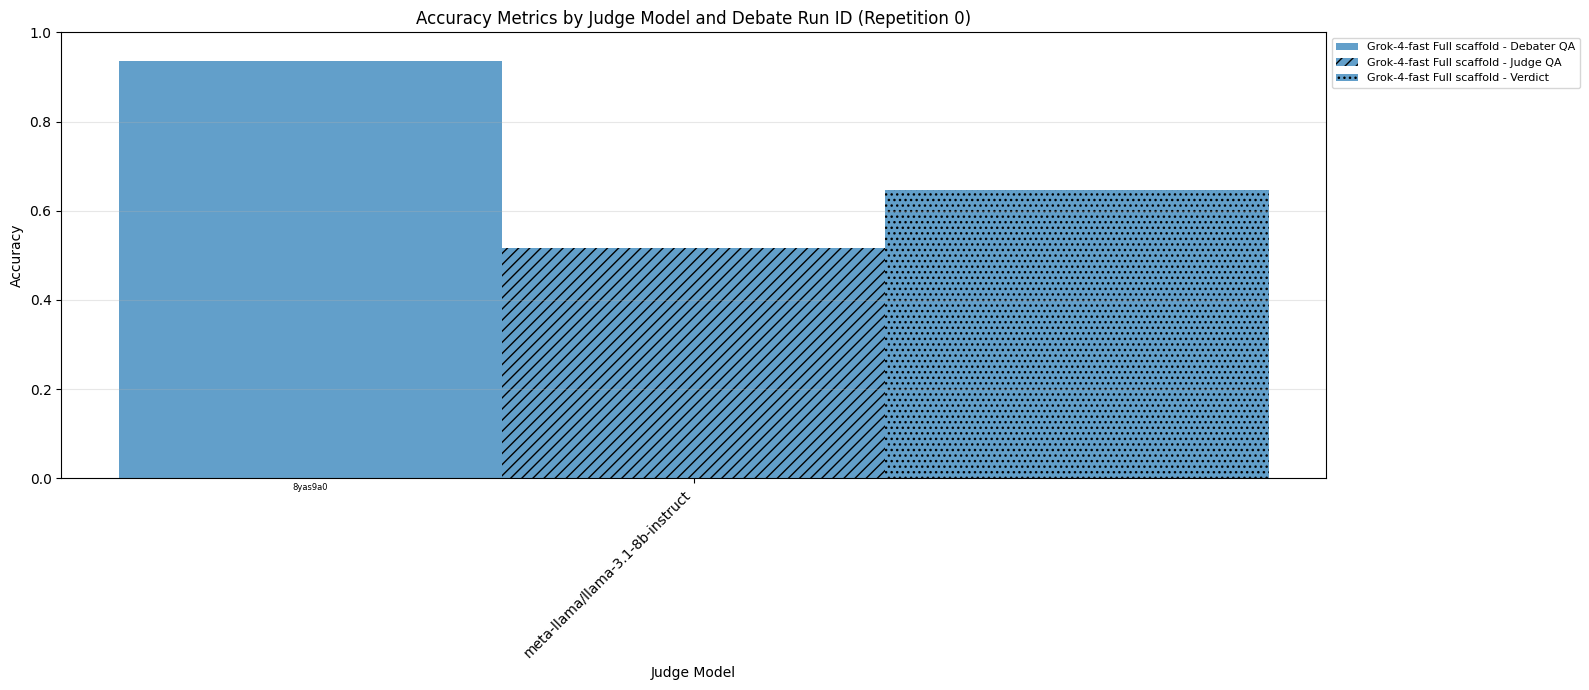

In [102]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

debate_run_id_labels = {
    'egkyot4': 'Gemini-3-pro Full scaffold',
    'ts9ga4y': 'Grok-4-fast Full scaffold',
    'txd06z5': 'Grok-4-fast Minimal scaffold',
    'wcsck4w': 'gpt-4o-mini Full scaffold',
    'yn1vu8h': 'gpt-4o-mini Minimal scaffold'
}

run_mapping = pd.DataFrame(data['runs'])
merged = aggregate_acc.merge(run_mapping, left_on='name', right_on='verdict_run_id')

metrics = ['debater_qa_acc', 'judge_qa_acc', 'verdict_acc']
metric_labels = ['Debater QA', 'Judge QA', 'Verdict']

for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    debate_run_ids = sorted(plot_data['debate_run_id'].unique())
    
    n_judges = len(judge_models)
    n_debates = len(debate_run_ids)
    n_metrics = len(metrics)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (n_debates * n_metrics)
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    colors = plt.cm.tab10(np.linspace(0, 1, n_debates))
    hatches = ['', '///', '...']
    
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, (metric, metric_label) in enumerate(zip(metrics, metric_labels)):
            values = []
            verdict_run_ids = []
            for judge_model in judge_models:
                row = plot_data[(plot_data['model'] == judge_model) & 
                               (plot_data['debate_run_id'] == debate_run_id)]
                if len(row) > 0:
                    values.append(row[metric].values[0])
                    verdict_run_ids.append(row['verdict_run_id'].values[0])
                else:
                    values.append(0)
                    verdict_run_ids.append('')
            
            offset = (i - n_debates / 2 + 0.5) * (group_width / n_debates) + (j - n_metrics / 2 + 0.5) * width
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}" if j == 0 else ""
            bars = ax.bar(x + offset, values, width, label=label, color=colors[i], alpha=0.7, hatch=hatches[j])
            
            for k, (bar, verdict_run_id) in enumerate(zip(bars, verdict_run_ids)):
                if verdict_run_id and j == 0:
                    ax.text(bar.get_x() + bar.get_width() / 2, -0.01, verdict_run_id,
                           ha='center', va='top', fontsize=6)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    ax.set_title(f'Accuracy Metrics by Judge Model and Debate Run ID (Repetition {run_idx})')
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    
    from matplotlib.patches import Patch
    legend_elements = []
    for i, debate_run_id in enumerate(debate_run_ids):
        for j, metric_label in enumerate(metric_labels):
            label = f"{debate_run_id_labels.get(debate_run_id, debate_run_id)} - {metric_label}"
            legend_elements.append(Patch(facecolor=colors[i], alpha=0.7, hatch=hatches[j], label=label))
    ax.legend(handles=legend_elements, loc='upper left', bbox_to_anchor=(1, 1), fontsize=8)
    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()


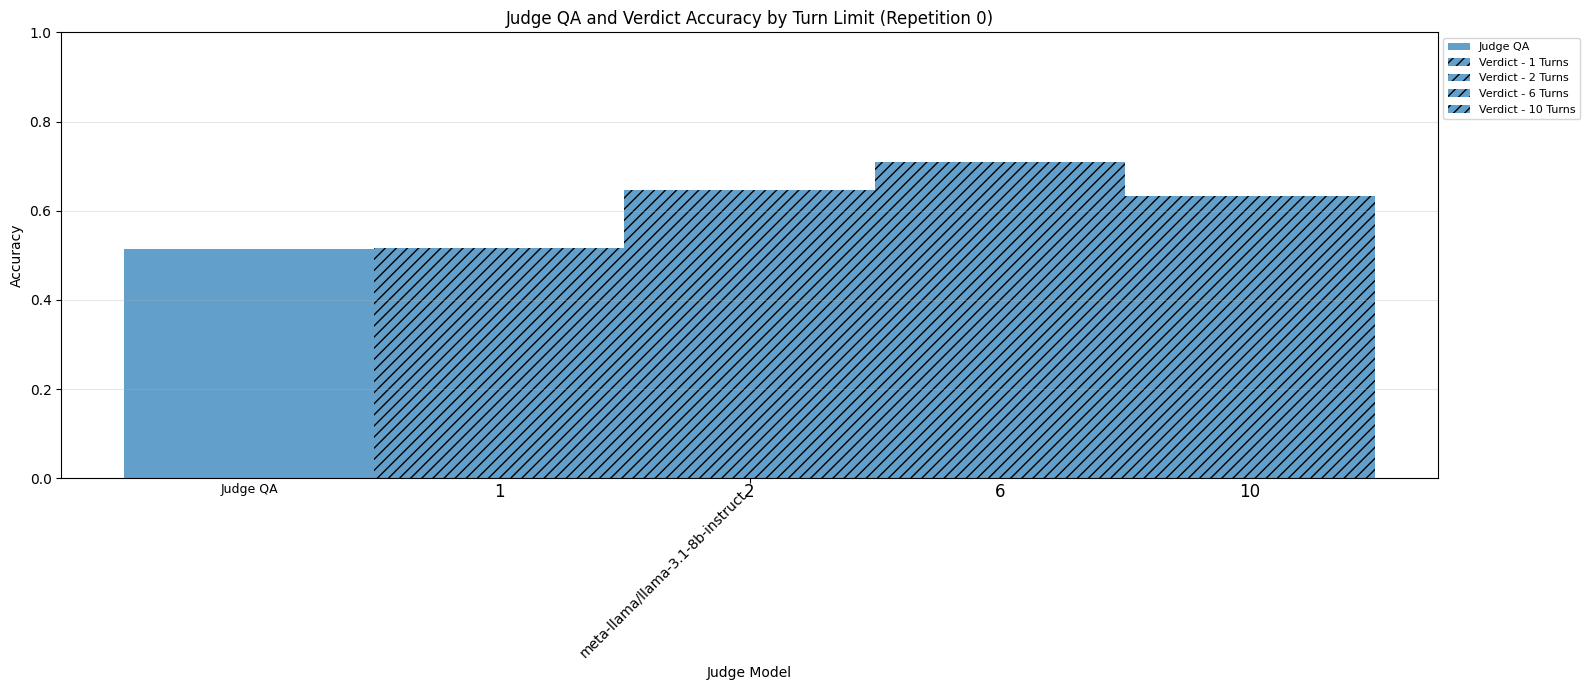

In [ ]:
for run_idx in [0]:
    plot_data = merged[merged['run_idx'] == run_idx].copy()
    
    judge_models = sorted(plot_data['model'].unique())
    
    if 'upto_turns' in plot_data.columns:
        upto_turns_list = sorted(plot_data['upto_turns'].dropna().unique())
    else:
        upto_turns_list = [None]
    
    n_judges = len(judge_models)
    n_turns = len(upto_turns_list)
    
    x = np.arange(n_judges)
    group_width = 0.8
    width = group_width / (1 + n_turns)
    
    bar_color = plt.cm.tab10(0)
    hatches = ['', '///']
    
    fig, ax = plt.subplots(figsize=(16, 7))
    
    judge_qa_values = []
    for judge_model in judge_models:
        rows = plot_data[plot_data['model'] == judge_model]
        if len(rows) > 0:
            avg_value = rows['judge_qa_acc'].mean()
            judge_qa_values.append(avg_value)
        else:
            judge_qa_values.append(0)
    
    judge_qa_offset = -group_width / 2 + width / 2
    bars_judge_qa = ax.bar(x + judge_qa_offset, judge_qa_values, width, label='Judge QA', color=bar_color, alpha=0.7, hatch=hatches[0])
    
    for bar in bars_judge_qa:
        ax.text(bar.get_x() + bar.get_width() / 2, -0.01, 'Judge QA',
               ha='center', va='top', fontsize=9)
    
    for i, upto_turns in enumerate(upto_turns_list):
        if upto_turns is not None:
            turn_data = plot_data[plot_data['upto_turns'] == upto_turns].copy()
        else:
            turn_data = plot_data.copy()
        
        verdict_values = []
        for judge_model in judge_models:
            rows = turn_data[turn_data['model'] == judge_model]
            if len(rows) > 0:
                avg_value = rows['verdict_acc'].mean()
                verdict_values.append(avg_value)
            else:
                verdict_values.append(0)
        
        offset = judge_qa_offset + width + i * width
        label = f"{upto_turns if upto_turns is not None else 'All'} Turns"
        bars = ax.bar(x + offset, verdict_values, width, label=label, color=bar_color, alpha=0.7, hatch=hatches[1])
        
        for k, bar in enumerate(bars):
            turn_label = f"{upto_turns if upto_turns is not None else 'All'}"
            ax.text(bar.get_x() + bar.get_width() / 2, -0.01, turn_label,
                   ha='center', va='top', fontsize=12)
    
    ax.set_xlabel('Judge Model')
    ax.set_ylabel('Accuracy')
    title = f'Judge QA and Verdict Accuracy by Turn Limit'
    if run_idx is not None:
        title += f' (Repetition {run_idx})'
    ax.set_title(title)
    ax.set_xticks(x)
    ax.set_xticklabels(judge_models, rotation=45, ha='right')
    

    
    ax.grid(axis='y', alpha=0.3)
    ax.set_ylim([0, 1])
    
    plt.tight_layout()
    plt.show()
